# About RBMs

Let us assume we have $d$ visible units and $n$ hidden units.


Energy of an RBM

$$
E(v,h) = - c^Tv - b^Th - h^t W v
$$

Probability of an assignment of hidden and visible units:

$$
P(v,h) = - \frac{ e^{-E(v,h)} } { \sum_{( \bar{v},\bar{h}) \in \{0,1\}^d x \{0,1\}^n } e^{-E(\bar{v},\bar{h})} }
$$

In [1]:
import sys
import os
import inspect
#sys.path.insert(0,'..')

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent =  os.path.dirname(currentdir) + '/RBM'
sys.path.insert(0,parent)

%load_ext autoreload
%autoreload 2
%matplotlib inline

from timeit import default_timer as timer
import numpy as np
import time
import matplotlib.pyplot as plt
import numexpr  as ne
import profile
import rbm
import pandas

## Read the MNIST without labels

In [2]:
X = pandas.read_csv("../Datasets/MNIST/test_mnist.csv").values
X_ = pandas.read_csv("../Datasets/MNIST/train_mnist.csv")
X_= X_[X_.columns[1:]].values
X = np.concatenate((X, X_), axis=0) 
del(X_)

print('\t files read')
X = np.array(X>4, dtype ='float32')

saved_models_folder = "saved_models"
visible_dim = X.shape[1]
hidden_dim = 225
epochs = 100
K = 1
lr = 0.1
batch_size = 500

Xaux = np.array(X, dtype='float32')

	 files read


## Define an RBM and train it



In [10]:
rbm_ = rbm.RBM(visible_dim=visible_dim,
               hidden_dim=hidden_dim,
               seed=42,
               mu=0, 
               sigma=0.3,
               monitor_time=True)

In [11]:
rbm_.fit(Xaux, 
         method='vectorized_CDK',
         K=K,
         lr=lr,
         epochs=epochs,
         batch_size=batch_size,
         plot_weights=False)

epoch 100/ 100	time per epoch: 5.17	 total time: 535.62

## Looking for similar images in the original representation

In [21]:
# take an example within the dataset
query = Xaux[30]

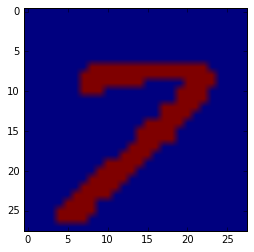

In [22]:
plt.imshow(query.reshape(28,28))

In [23]:
# find the closest examples to que query using the original representation
def find_similar(X,query,num_retrieved=10):
    dif = (X - query)
    distances = np.linalg.norm(dif,axis=1)
    closest_to_query = distances.argsort()
    return X[closest_to_query[1:num_retrieved]]

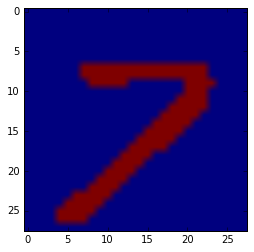

In [24]:
similar_patterns = find_similar(X, Xaux[30], num_retrieved=20)
similar_patterns_as_matrices = [ x.reshape(28,28) for x in similar_patterns]
plt.imshow(similar_patterns_as_matrices[0])

In [58]:
def plot_images(X):
    min_max_scale=True
    for i, x in enumerate(X):
        plt.subplot(25,25,i+1)
        plt.imshow(x, cmap= plt.get_cmap('gray'))


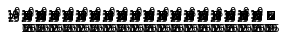

In [59]:
plot_images(similar_patterns_as_matrices)

## Plot the weights after training

### Plot the incoming weight to hidden unit j with "plot_weight"

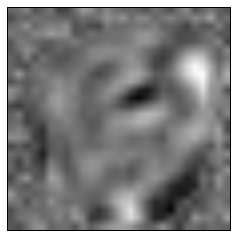

In [46]:
rbm_.plot_weight(1)

### Plot the weights of all hidden units with ".plot_weights"

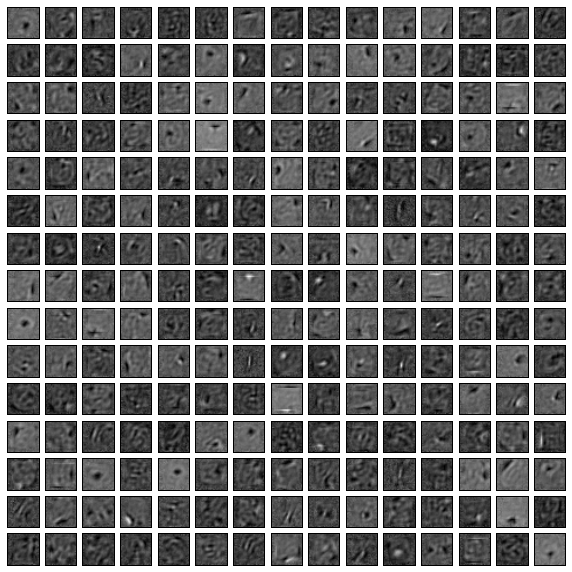

In [47]:
rbm_.plot_weights(min_max_scale = True)

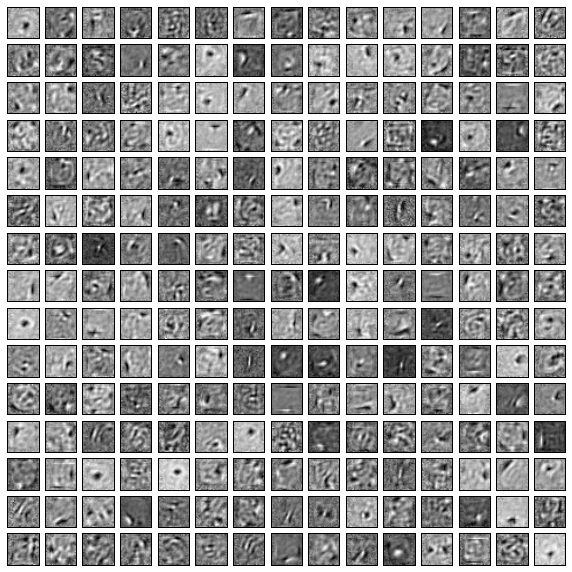

In [48]:
rbm_.plot_weights(min_max_scale = False)

## Compute the probability of a visible vector  

To compute the probability of a visible vector $\pmb{x}$ you have to marginalize over the hidden states of the RBM. That is

$$
P(\pmb{x}) = \sum_{ \pmb{h} \in \mathcal{H}} P(\pmb{x}, \pmb{h}) 
$$

This exact inference method might be impractible if the number of elements in $ \mathcal{H}$ is too big.

Notice that $2^{20}=1048576$ is already a big number.  $2^{100}$ is an impracticable number for computing the exact probability of a visible vector even though 100 hidden units is a rather small number of units compared to a MLP.

In [49]:
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent =  os.path.dirname(currentdir) + '/RBM'
sys.path.insert(0,parent)

# Load the data
X = pandas.read_csv("../Datasets/MNIST/test_mnist.csv").values
X_ = pandas.read_csv("../Datasets/MNIST/train_mnist.csv")
X_= X_[X_.columns[1:]].values
X = np.concatenate((X, X_), axis=0) 
del(X_)
print('\t files read')
X = np.array(X>4, dtype ='float32')


# Info about the model
saved_models_folder = "saved_models"
visible_dim = X.shape[1]
hidden_dim = 12
epochs = 100
K = 1
lr = 0.1
batch_size = 500
Xaux = np.array(X, dtype='float32')

#instanciate the model
rbm_ = rbm.RBM(visible_dim=visible_dim,
               hidden_dim=hidden_dim,
               seed=42,
               mu=0, 
               sigma=0.3,
               monitor_time=True)

	 files read


In [50]:
print(rbm_.W.shape)
print(rbm_.b.shape)

(784, 12)
(784,)


In [52]:
rbm_.fit(Xaux, 
         method='vectorized_CDK',
         K=2,
         lr=0.01,
         epochs=50,
         batch_size=500,
         plot_weights=False)

epoch 50/ 50	time per epoch: 4.52	 total time: 233.77

In order to compute the probability of a visible vector we should compute:
$$
P(\pmb{x}) = \sum_{ \pmb{h} \in \mathcal{H}} P(\pmb{x}, \pmb{h}) = - \sum_{ \pmb{h} \in \mathcal{H}} \frac{ e^{-E(\pmb{x},\pmb{h})} } { \sum_{( \bar{\pmb{x}},\bar{\pmb{h}}) \in \{0,1\}^d x \{0,1\}^n } e^{-E(\bar{\pmb{x}},\bar{\pmb{h}})} }
$$
The denominator of the previous equation is constant. Since it does not depend on the presented input vector $\pmb{x}$ we just need to compute it once. This term is also called the partition function $Z$
 $$
 Z = \sum_{( \bar{\pmb{x}},\bar{\pmb{h}}) \in \{0,1\}^d x \{0,1\}^n } e^{-E(\bar{\pmb{x}},\bar{\pmb{h}})} 
 $$

Notice that the sum is over $2^d \cdot 2^n$ terms. Since d=784 in the MNIST case this is an impracticable thing to compute since a for loop over $2^{784} \cdot 2^{12}$ states is impracticable.

This is not the end of the story though. It turns out that this quantity can be computed with complexity determined by the minimum between the number of input units and the number of hidden units. If both quantities are above a reasonably big number, for example 100 , then more than $2^{100}$ computations will not be posible.

#### More efficient expression of $P(\pmb{x})$

**Proposition**

$$
P(\pmb{x}) = \sum_{ \pmb{h} \in \mathcal{H}} P(\pmb{x}, \pmb{h}) =  \sum_{ \pmb{h} \in \mathcal{H}}  \frac{e^{-E(\pmb{x}, \pmb{h})}}{Z} = \frac{ e^{\pmb{c}^T \pmb{x} + \sum_{j=1}^H \log( 1 + e^{b_j + \pmb{W}_{j \cdot }\pmb{x} }  ) }}{Z}
$$

To make the notation less confusing we can write $e^\alpha$ as $\exp(\alpha)$. Using this notation the previous result states
$$
P(\pmb{x}) = \frac{ \exp(-E(\pmb{x}, \pmb{h}))}{Z} =
\frac{ \exp \big(\pmb{c}^T \pmb{x} + \sum_{j=1}^H \log( 1 + \exp(b_j + \pmb{W}_{j \cdot }\pmb{x}) ) \big) }{Z}
$$

Some people writes this result using the "free energy" which is the term inside the exponential

$$
P(\pmb{x}) = \frac{exp(-F(\pmb{x}))}{Z}
$$
**Demonstration**


\begin{equation}
\begin{split}
P(\pmb{x}) &= \sum_{ \pmb{h} \in \{0,1\}^d } P(\pmb{x}, \pmb{h}) & \\
           &= \sum_{ \pmb{h} \in \{0,1\}^d } P(\pmb{x}, \pmb{h})
\end{split}
\end{equation}


## Related papers

#### Investigating convergence of RBM learning:
- http://www.ais.uni-bonn.de/papers/nips10ws_schulz_mueller_behnke.pdf

## Interesting material


Some sources and interesting information:


#### Annealed Importance Sampling
- http://www.cs.toronto.edu/pub/radford/ais-rev.pdf

#### Approximate inference MIT deep learning:
- http://goodfeli.github.io/dlbook/version-2015-10-18/contents/inference.html

#### Confronting the Partition Function:
- http://goodfeli.github.io/dlbook/version-2015-10-18/contents/partition.html


